# Improve Your Chances of Getting a Prosper Loan with Low APR
## A Borrower's Guide
### by Truls Møller

## Investigation Overview

Getting a loan is sometimes the solution when you need some short-term financial flexibility in life, and Prosper provides  personal loans for a wide array of purposes, with 1-, 3- or 5- year duration. In size Prosper loans range from \\$2k - \\$35k, with an average size of around \\$8k.

We will look into what will help the borrower seeking such a loan when it comes to:

- **Being granted a loan**. A key factor is your credit rating, which should be at least decent.

- **Getting the best possible interest rate**. Some key factors to positively affect your APR: Prosper Rating, Annual salary and Home ownership. In Prosper terminology the __Annual Percentage Rate (APR)__ is what you want to minimize. 


## Dataset Overview

The data consisted of attributes of approximately 114,000 loans. The attributes included basic loan data such as date, listing catgory, amount, annual interest rate and duration, Prosper Rating and Credit Rating, as well as additional information on the borrower such as employment status, income range and homeownership status. Close to seventy data points were removed/skipped from the analysis due to inconsistencies or irrelevance to the key insights.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# set base color for use in seaborn plots
base_color = sb.color_palette()[0]

In [3]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

## Necessary data wrangling steps

In [4]:
# We convert the 'Date' columns to datetime format

date_columns = ['ListingCreationDate', 'ClosedDate', 'DateCreditPulled', 'LoanOriginationDate']

for i in date_columns:
    df[i]= pd.to_datetime(df[i]).dt.normalize()

In [5]:
# We add a new column with for the Loan Origination YEAR.

df['Year'] = df['LoanOriginationDate'].dt.year

In [6]:
# We convert 'ListingNumber' and 'Term' to string type

df['ListingNumber'] = df['ListingNumber'].astype('str')
df['Term'] = df['Term'].astype('str')

In [7]:
# We create the new column where we first take all the data from column 'ProsperRating (Alpha)'s 
# and then populate its missing values (pre-2009) with data from 'CreditGrade'.

df['ProsperRating'] = df['ProsperRating (Alpha)'].fillna(df['CreditGrade'])

# We check for missing data in our new column
df['ProsperRating'].isna().sum()

131

In [8]:
# We remove the missing data with pandas notnull function

df = df[pd.notnull(df['ProsperRating'])]

In [9]:
# The CreditGrade column also carried an extra value 'NC', 
# which we interpret as missing data as well ("Not Counted")
# We drop those entries

df = df[df.ProsperRating != 'NC']

In [39]:
df_income = df[(df.IncomeRange != 'Not displayed') & (df.IncomeRange != 'Not employed') & (df.IncomeRange != '$0')]

In [10]:
# We remove the missing data in 'BorrowerAPR' with pandas notnull function

df = df[pd.notnull(df['BorrowerAPR'])]

In [11]:
# We want to add a column 'ListingCategory' and populate it 
# based on 'ListingCategory (numeric)'.

# First we create a dict for mapping between them
d = {0 : '0. Not Available',
     1 : '1. Debt Consolidation',
     2 : '2. Home Improvement', 
     3 : '3. Business', 
     4 : '4. Personal Loan', 
     5 : '5. Student Use',
     6 : '6. Auto',
     7 : '7. Other',
     8 : '8. Baby and Adoption', 
     9 : '9. Boat', 
     10 : '10. Cosmetic Procedure', 
     11 : '11. Engagement Ring',
     12 : '12. Green Loans',
     13 : '13. Household Expenses',
     14 : '14. Large Purchases',
     15 : '15. Medical/Dental',
     16 : '16. Motorcycle',
     17 : '17. RV',
     18 : '18. Taxes',
     19 : '19. Vacation',
     20 : '20. Wedding Loans'}

# we initialize the new column:

df['ListingCategory'] = '0. Not Available'

# and then we populate it.

for key in d:
    df.loc[df['ListingCategory (numeric)'] == key,'ListingCategory'] = d[key]

In [12]:
# We convert Term, LoanStatus, ListingCategory and IncomeRange
# into ordered categorical types.

ordinal_var_dict = {'Term': ['12','36','60'],
                    'LoanStatus': ['Current', 'Completed','FinalPaymentInProgress', 
                                   'Past Due (1-15 days)', 'Past Due (16-30 days)', 
                                   'Past Due (31-60 days)', 'Past Due (61-90 days)', 
                                   'Past Due (90-120 days)', 'Past Due (>120 days)', 
                                   'Chargedoff', 'Defaulted'],
                    'ListingCategory': list(d.values()),
                    'IncomeRange': ['Not displayed', 'Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+'],
                    'EmploymentStatus': ['Employed', 'Self-employed', 'Full-time', 'Part-time', 'Retired', 'Other', 'Not employed', 'Not available'], 
                    'ProsperRating': ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

In [13]:
# We drop the rows with credit score range less than 400. There are only four of them.

ind = df[(df.CreditScoreRangeLower < 400) | (df.CreditScoreRangeUpper < 400)].index

df = df.drop(ind)

In [14]:
# We create a new column 'CreditScore' which is the average of the upper and the lower range that we have
df['CreditScore'] = (df['CreditScoreRangeUpper'] + df['CreditScoreRangeLower'])/2.0

In [19]:
# For creating adaptable lineplots, we make a custom function "mean_poly".
def mean_poly(x, y, bins = 10, **kwargs):
    """ Custom adapted line plot code. """
    # set bin edges if none or int specified
    if type(bins) == int:
        bins = np.linspace(x.min(), x.max(), bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # compute counts
    data_bins = pd.cut(x, bins, right = False,
                       include_lowest = True)
    means = y.groupby(data_bins).mean()

    # create plot
    plt.errorbar(x = bin_centers, y = means, **kwargs)

## Historical Chart of Prosper Loan Listings

After 2-3 years of business the 2008 financial crisis hit. We can see there is a gap in the data between the fall of 2008 and the mid of 2009. After the mid of 2009 the volume picks up for Prosper and, after a dip in late 2012, it takes off and the volume more than doubles the next 12 months!

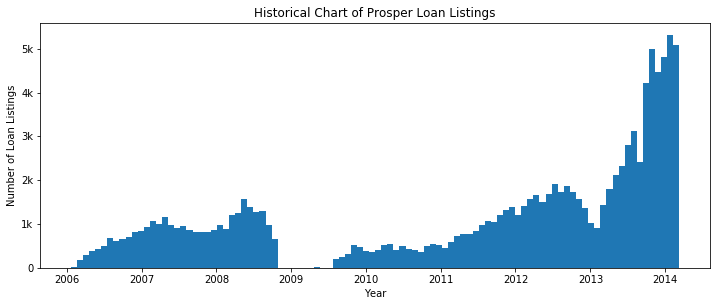

In [15]:
plt.figure(figsize = [12,4.5])

plt.hist(df["LoanOriginationDate"], bins = 100)

plt.xlabel('Year')
plt.yticks([0, 1e3, 2e3, 3e3, 4e3, 5e3], [0, '1k', '2k', '3k', '4k', '5k'])
plt.ylabel('Number of Loan Listings')
plt.title('Historical Chart of Prosper Loan Listings');

## Prosper Rating and Annual Percentage Rate (APR)

The Prosper Rating almost dictates the Annual Percentage Rate (APR).

Getting the best possible Prosper Rating is really important for a borrower. The problem is that it's kind of a black box - we do not know exactly how it's calculated. 

We will look at some other factors as well. And rather than linking them to the black box Prosper Rating we will link them to the APR directly.

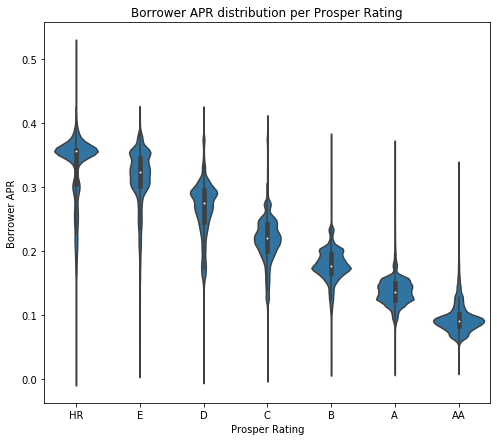

In [70]:
plt.figure(figsize = [8, 7])
sb.violinplot(data = df, x='ProsperRating', y='BorrowerAPR', color=base_color)
plt.xlabel('Prosper Rating')
plt.ylabel('Borrower APR')
plt.title('Borrower APR distribution per Prosper Rating');

## Credit Score Importance in Getting a Loan

Pre-2009 your credit score wouldn't stop you from getting a loan even if it was as low as 500, but from 2009 onwards none of the borrowers at Prosper have a credit score of less than 600. It doesn't exist.

Based on recent history and for a decent shot at getting a Prosper loan your credit rating should be at least 650.

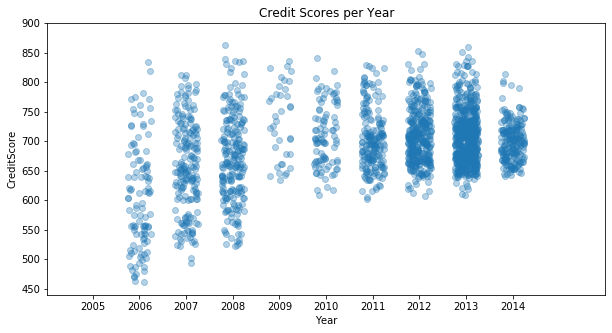

In [42]:
df_sample = df.sample(2000)

plt.figure(figsize = [10, 5])

sb.regplot(data = df_sample, x = 'Year', y = 'CreditScore', fit_reg = False, 
           y_jitter = 10, x_jitter = 0.25, scatter_kws = {'alpha' : 1/3})

plt.xticks(np.arange(2005, 2014 + 1, 1))
plt.yticks(np.arange(450, 900 + 50, 50))
plt.title('Credit Scores per Year');

## A High Credit Score Likely Will Improve Your APR

The plot shows the relationship between Credit Score and APR per Year. The trend for each year is that a high credit score predicts a better (lower) APR.

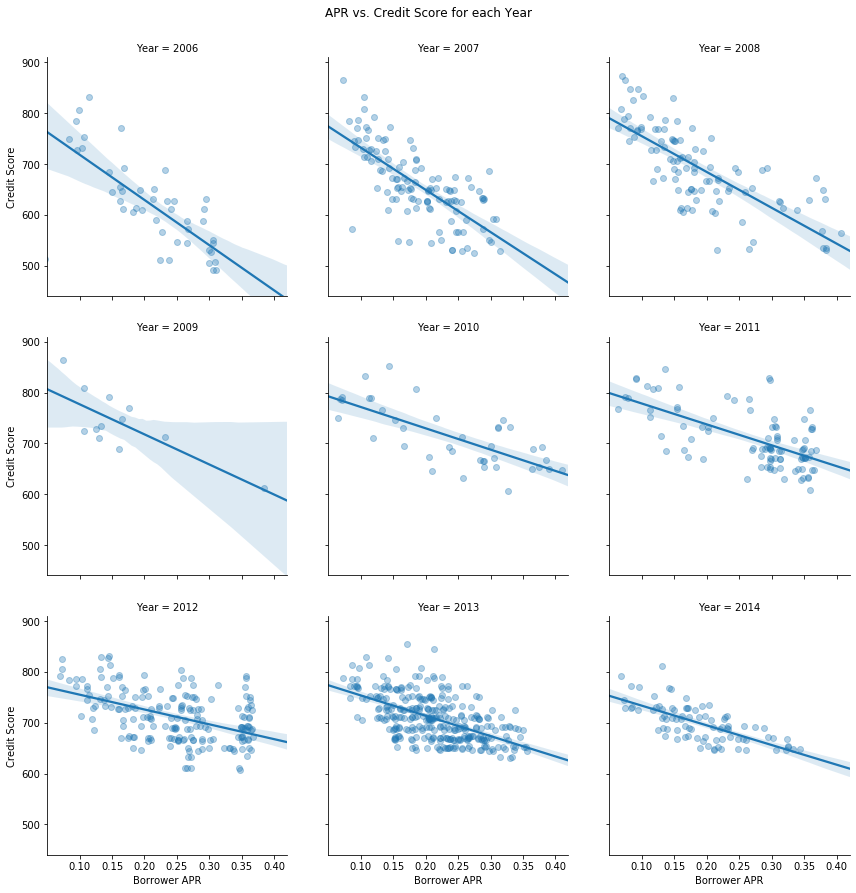

In [92]:
df_sample = df.sample(1000)

g = sb.lmplot(x="BorrowerAPR", y="CreditScore", col = "Year", 
              data=df_sample, col_wrap=3, height=4, 
              y_jitter = 5., x_jitter = 0.01, 
              scatter_kws = {'alpha' : 1/3}, palette = base_color);

g = (g.set_axis_labels("Borrower APR", "Credit Score")
    .set(ylim=(440, 910), xlim=(0.05, 0.42),
    yticks=[500, 600, 700, 800, 900], xticks=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
    .fig.subplots_adjust(hspace=.17, wspace=.17))

plt.suptitle('APR vs. Credit Score for each Year', y = 1.03);

## Income Matters
If you want a low APR it really helps having a high income. Observe how non-overlapping the plotted lines are. Though, keep in mind these are yearly average APR for each income range.

So, if your salary has increased recently, make sure Prosper has up to date information on this!

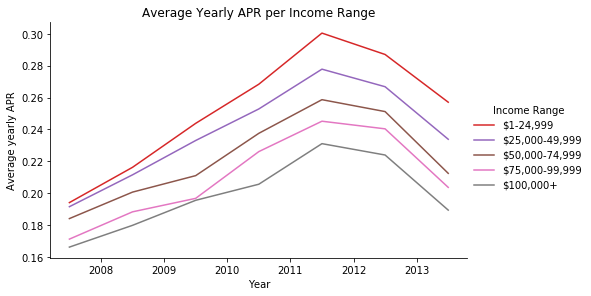

In [55]:
bin_edges = np.arange(2006, df['Year'].max()+1, 1)

g = sb.FacetGrid(data = df_income, hue = 'IncomeRange', height = 4, aspect = 1.7)

g.map(mean_poly, "Year", "BorrowerAPR", bins = bin_edges)
g.set_ylabels('Average yearly APR')
g.add_legend(title = 'Income Range', label_order = ['$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+'])
plt.title('Average Yearly APR per Income Range');

## Homeownership Matters
In addition to having a high income being a home owner will also contribute positively and could reduce your APR. On average this is the case for each and every income category and will predict a reduced interest rate of 1-2 percentage points. So if you are a homeowner, make sure Prosper knows!

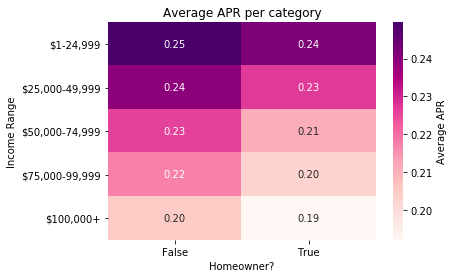

In [93]:
cat_means = df_income.groupby(['IsBorrowerHomeowner', 'IncomeRange']).mean()['BorrowerAPR']
cat_means = cat_means.dropna()
cat_means = cat_means.reset_index(name = 'BorrowerAPR_avg')
cat_means = cat_means.pivot(index = 'IncomeRange', columns = 'IsBorrowerHomeowner',
                            values = 'BorrowerAPR_avg')

plt.figure(figsize = [6, 4])

sb.heatmap(cat_means, annot = True, fmt = '.2f',
           cbar_kws = {'label' : 'Average APR'}, cmap="RdPu")
plt.xlabel('Homeowner?')
plt.ylabel('Income Range')
plt.title('Average APR per category');

## Conclusion
Obviously, a lender like Prosper will prefer solid borrowers and offer the best interest rates to their preferred customers. What seems to matter the most to them is income, first and foremost, but capital also seems to matter.

1. Income - if your income is low, is there any way you can increase it? Regardsless make sure Prosper knows about your full income
2. Capital - are you a homeowner? If so, make sure Prosper knows about it, along with any other capital you might have.

You as the potential Borrower should of course try to negotiate with Prosper to get a low APR. At the same time be aware that income and capital are what they care about the most. 

And make sure your Credit Rating is 650 or higher. Otherwise, your chances of getting a loan in the first place are probably slim.

Best of luck!